# Debug Notebook: Snapshot/Restore for GRPO Support

This notebook helps debug the snapshot/restore functionality step-by-step.

## Prerequisites
1. Start the server externally: `python microservice_manager.py --num-services 1`
2. Wait for CARLA to fully initialize (~60 seconds)
3. Run cells sequentially to debug each phase

## Setup and Imports

In [6]:
import subprocess, re

def kill_carla_processes_on_gpu(gpu_index: int = 0):
    """Kill CARLA processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\+G\s+.*CarlaUE4'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No CarlaUE4 processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing CarlaUE4 process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing CARLA processes: {e}")

def kill_python_processes_on_gpu(gpu_index: int = 0):
    """Kill Python processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\s+.*bin/python'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No python processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing python process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing Python processes: {e}")

def cleanup_gpu_processes():
    """Clean up GPU processes"""
    for gpu_id in [0, 1]:
        kill_carla_processes_on_gpu(gpu_id)
        kill_python_processes_on_gpu(gpu_id)

cleanup_gpu_processes()

No CarlaUE4 processes found on GPU 0
No python processes found on GPU 0
No CarlaUE4 processes found on GPU 1
No python processes found on GPU 1


In [7]:
import sys
import os
import json
import time
import base64
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple, List
from IPython.display import display, clear_output

root_path = '/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices'

# Add parent directory to path
if root_path not in sys.path:
    sys.path.append(root_path)

print("Imports successful")

Imports successful


## Configuration

In [8]:
# Server configuration
SERVER_URL = "http://localhost:8080"
ROUTE_ID = 0

# Test configuration
PHASE1_STEPS = 50  # Initial straight driving
PHASE2_STEPS = 50  # Continued straight driving
PHASE3_STEPS = 50  # Restored with right turn

# Output directories
OUTPUT_DIR = "debug_snapshots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Server URL: {SERVER_URL}")
print(f"Output directory: {OUTPUT_DIR}")

Server URL: http://localhost:8080
Output directory: debug_snapshots


## Helper Functions

In [9]:
def extract_image_from_observation(obs: Dict, key: str = 'center') -> Optional[np.ndarray]:
    """Extract and decode image from observation"""
    try:
        if 'images' in obs and key in obs['images']:
            img_data = obs['images'][key]
            if img_data.startswith('data:image'):
                img_data = img_data.split(',')[1]
            img_bytes = base64.b64decode(img_data)
            img = Image.open(BytesIO(img_bytes))
            return np.array(img)
    except Exception as e:
        print(f"Error extracting image: {e}")
    return None

def extract_position_from_observation(obs: Dict) -> Optional[Tuple[float, float, float]]:
    """Extract vehicle position from observation"""
    try:
        if 'vehicle_state' in obs:
            state = obs['vehicle_state']
            if 'position' in state:
                pos = state['position']
                return (pos.get('x', 0), pos.get('y', 0), pos.get('z', 0))
            elif 'location' in state:
                loc = state['location']
                return (loc.get('x', 0), loc.get('y', 0), loc.get('z', 0))
    except Exception as e:
        print(f"Error extracting position: {e}")
    return None

def display_step_info(step: int, position: Tuple[float, float, float], 
                     action: Dict, image: Optional[np.ndarray] = None):
    """Display information about current step"""
    print(f"\nStep {step}:")
    print(f"  Position: x={position[0]:.2f}, y={position[1]:.2f}, z={position[2]:.2f}")
    print(f"  Action: throttle={action['throttle']:.1f}, steer={action['steer']:.1f}, brake={action['brake']:.1f}")
    
    if image is not None:
        plt.figure(figsize=(8, 4))
        plt.imshow(image)
        plt.title(f"Step {step} - Camera View")
        plt.axis('off')
        plt.show()

print("Helper functions defined")

Helper functions defined


## Server Connection Test

In [10]:
# Test server connection
try:
    response = requests.get(f"{SERVER_URL}/health")
    health = response.json()
    print("health", health)
    print("✅ Server is healthy")
    print(f"Server ID: {health['server_id']}")
    print(f"Has evaluator: {health['has_evaluator']}")
    print(f"Step count: {health['step_count']}")
except Exception as e:
    print(f"❌ Failed to connect to server: {e}")
    print("Make sure the server is running: python microservice_manager.py --num-services 1")

health {'status': 'healthy', 'server_id': 'service-0', 'step_count': 0, 'has_evaluator': False}
✅ Server is healthy
Server ID: service-0
Has evaluator: False
Step count: 0


## Initialize Environment

Resetting environment with route_id=0
This may take 60-120 seconds on first run...
response <Response [200]>
✅ Environment reset successful!
Initial position: x=592.31, y=3910.66, z=371.27


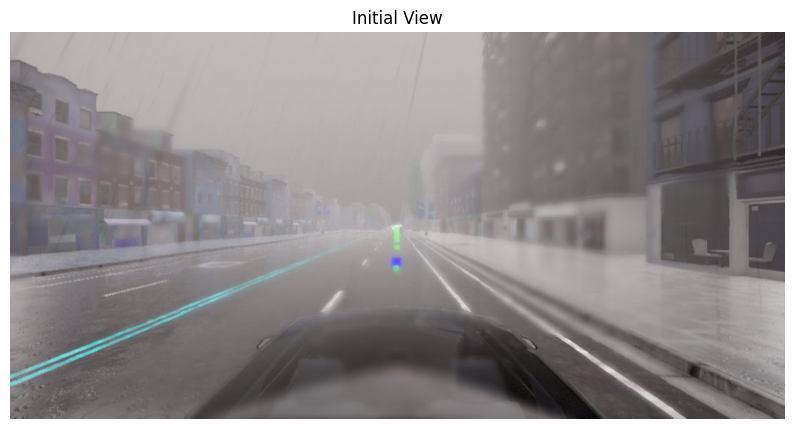

In [11]:
# Reset environment
print(f"Resetting environment with route_id={ROUTE_ID}")
print("This may take 60-120 seconds on first run...")

reset_data = {"route_id": ROUTE_ID}
response = requests.post(f"{SERVER_URL}/reset", json=reset_data, timeout=180)
print("response", response)

if response.status_code == 200:
    reset_response = response.json()
    initial_obs = reset_response['observation']
    print("✅ Environment reset successful!")
    
    # Extract and display initial state
    initial_pos = extract_position_from_observation(initial_obs)
    if initial_pos:
        print(f"Initial position: x={initial_pos[0]:.2f}, y={initial_pos[1]:.2f}, z={initial_pos[2]:.2f}")
    
    # Display initial image
    initial_img = extract_image_from_observation(initial_obs)
    if initial_img is not None:
        plt.figure(figsize=(10, 6))
        plt.imshow(initial_img)
        plt.title("Initial View")
        plt.axis('off')
        plt.show()
else:
    print(f"❌ Reset failed: {response.status_code}")
    print(response.text)

## Phase 1: Initial Driving (50 steps straight)

PHASE 1: Initial straight driving for 50 steps
initial_pos (592.309814453125, 3910.655029296875, 371.2745361328125)
Step 10/50: Position: x=592.31, y=3910.66
Step 20/50: Position: x=591.66, y=3910.66
Step 30/50: Position: x=589.46, y=3910.67
Step 40/50: Position: x=585.74, y=3910.70
Step 50/50: Position: x=580.42, y=3910.73


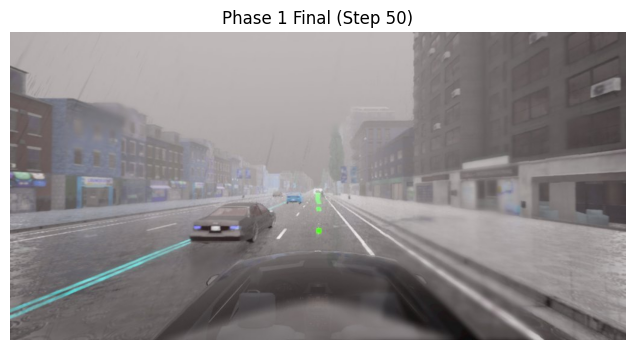


Phase 1 Summary:
Start position: x=592.31, y=3910.66
End position: x=580.42, y=3910.73
Distance traveled: 11.89


In [12]:
# Data collection for Phase 1
phase1_positions = []
phase1_images = []

print("="*60)
print("PHASE 1: Initial straight driving for 50 steps")
print("="*60)

# Get initial position
initial_pos = extract_position_from_observation(initial_obs)
print("initial_pos", initial_pos)
phase1_positions.append({'step': 0, 'x': initial_pos[0], 'y': initial_pos[1], 'z': initial_pos[2]})

# Drive straight for 50 steps
for step in range(1, PHASE1_STEPS + 1):
    # Action: straight driving
    action = {
        "throttle": 1.0,
        "brake": 0.0,
        "steer": 0.0
    }
    
    # Send step command
    response = requests.post(f"{SERVER_URL}/step", json={"action": action})
    
    if response.status_code == 200:
        step_data = response.json()
        obs = step_data['observation']
        
        # Extract position
        pos = extract_position_from_observation(obs)
        if pos:
            phase1_positions.append({
                'step': step,
                'x': pos[0],
                'y': pos[1],
                'z': pos[2],
                'action': action
            })
        
        # Show progress every 10 steps
        if step % 10 == 0:
            print(f"Step {step}/{PHASE1_STEPS}: Position: x={pos[0]:.2f}, y={pos[1]:.2f}")
            
            # Optionally show image
            if step == PHASE1_STEPS:  # Show final image
                img = extract_image_from_observation(obs)
                if img is not None:
                    phase1_images.append(img)
                    plt.figure(figsize=(8, 4))
                    plt.imshow(img)
                    plt.title(f"Phase 1 Final (Step {step})")
                    plt.axis('off')
                    plt.show()
    else:
        print(f"❌ Step {step} failed: {response.status_code}")
        break

# Summary
print("\n" + "="*40)
print("Phase 1 Summary:")
print(f"Start position: x={phase1_positions[0]['x']:.2f}, y={phase1_positions[0]['y']:.2f}")
print(f"End position: x={phase1_positions[-1]['x']:.2f}, y={phase1_positions[-1]['y']:.2f}")
print(f"Distance traveled: {abs(phase1_positions[-1]['x'] - phase1_positions[0]['x']):.2f}")
print("="*40)

## Create Snapshot (Branching Point)

In [13]:
# Create snapshot for GRPO branching
print("="*60)
print("CREATING SNAPSHOT FOR GRPO BRANCHING")
print("="*60)

snapshot_id = "debug_snapshot_grpo"
snapshot_request = {"snapshot_id": snapshot_id}

response = requests.post(f"{SERVER_URL}/snapshot", json=snapshot_request)

if response.status_code == 200:
    snapshot_response = response.json()
    print("✅ Snapshot created successfully!")
    print(f"Snapshot ID: {snapshot_response['snapshot_id']}")
    print("\nSnapshot statistics:")
    for key, value in snapshot_response['stats'].items():
        print(f"  {key}: {value}")
    
    # Save snapshot position for reference
    snapshot_position = phase1_positions[-1]
    print(f"\nSnapshot position: x={snapshot_position['x']:.2f}, y={snapshot_position['y']:.2f}, z={snapshot_position['z']:.2f}")
else:
    print(f"❌ Snapshot creation failed: {response.status_code}")
    print(response.text)

CREATING SNAPSHOT FOR GRPO BRANCHING
✅ Snapshot created successfully!
Snapshot ID: debug_snapshot_grpo

Snapshot statistics:
  vehicles: 13
  pedestrians: 0
  traffic_lights: 1101
  has_scenario_manager: True
  manager_tick: 51
  manager_running: True
  ego_vehicles: 1
  other_actors: 0

Snapshot position: x=580.42, y=3910.73, z=371.30


## Phase 2: Continue Straight (Original Timeline)

PHASE 2: Continue straight driving (original timeline)
Step 60/100: Position: x=573.71, y=3910.78
Step 70/100: Position: x=565.88, y=3910.83
Step 80/100: Position: x=557.04, y=3910.89
Step 90/100: Position: x=547.38, y=3910.96
Step 100/100: Position: x=536.94, y=3911.00


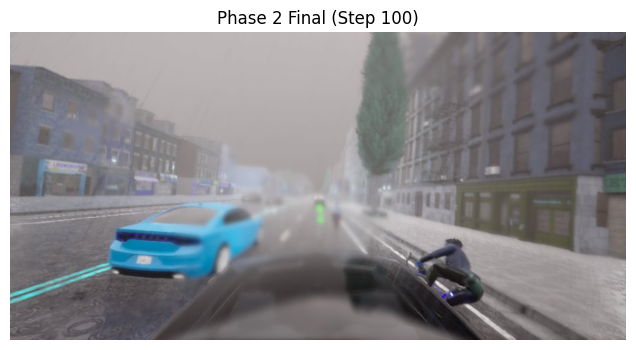


Phase 2 Summary:
Start position: x=579.80, y=3910.74
End position: x=536.94, y=3911.00
Distance traveled: 42.86


In [14]:
# Phase 2: Continue driving straight
phase2_positions = []
phase2_images = []

print("="*60)
print("PHASE 2: Continue straight driving (original timeline)")
print("="*60)

for step in range(PHASE1_STEPS + 1, PHASE1_STEPS + PHASE2_STEPS + 1):
    # Action: continue straight
    action = {
        "throttle": 1.0,
        "brake": 0.0,
        "steer": 0.0
    }
    
    # Send step command
    response = requests.post(f"{SERVER_URL}/step", json={"action": action})
    
    if response.status_code == 200:
        step_data = response.json()
        obs = step_data['observation']
        
        # Extract position
        pos = extract_position_from_observation(obs)
        if pos:
            phase2_positions.append({
                'step': step,
                'x': pos[0],
                'y': pos[1],
                'z': pos[2],
                'action': action
            })
        
        # Show progress every 10 steps
        if (step - PHASE1_STEPS) % 10 == 0:
            print(f"Step {step}/{PHASE1_STEPS + PHASE2_STEPS}: Position: x={pos[0]:.2f}, y={pos[1]:.2f}")
            
            # Show final image
            if step == PHASE1_STEPS + PHASE2_STEPS:
                img = extract_image_from_observation(obs)
                if img is not None:
                    phase2_images.append(img)
                    plt.figure(figsize=(8, 4))
                    plt.imshow(img)
                    plt.title(f"Phase 2 Final (Step {step})")
                    plt.axis('off')
                    plt.show()
    else:
        print(f"❌ Step {step} failed: {response.status_code}")
        break

# Summary
print("\n" + "="*40)
print("Phase 2 Summary:")
print(f"Start position: x={phase2_positions[0]['x']:.2f}, y={phase2_positions[0]['y']:.2f}")
print(f"End position: x={phase2_positions[-1]['x']:.2f}, y={phase2_positions[-1]['y']:.2f}")
print(f"Distance traveled: {abs(phase2_positions[-1]['x'] - phase2_positions[0]['x']):.2f}")
print("="*40)

In [15]:
# Request snapshot details
response = requests.get(f"{SERVER_URL}/snapshots")
snapshot_list_data = response.json()
snapshot_list_data

{'snapshots': [{'id': 'debug_snapshot_grpo',
   'source': 'memory+disk',
   'available': True,
   'file': 'snapshots/debug_snapshot_grpo.pkl',
   'size_kb': 334.1318359375},
  {'id': 'visual_test_snapshot',
   'source': 'disk',
   'file': 'snapshots/visual_test_snapshot.pkl',
   'size_kb': 335.75390625,
   'available': True},
  {'id': 'freeze_test',
   'source': 'disk',
   'file': 'snapshots/freeze_test.pkl',
   'size_kb': 329.4794921875,
   'available': True}],
 'count': 3,
 'snapshot_directory': '/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices/snapshots'}

In [16]:
### Manually download snapshot
import pickle

# Try loading from disk
snapshot_file = '/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices/snapshots/debug_snapshot_grpo.pkl'
with open(snapshot_file, 'rb') as f:
    snapshot = pickle.load(f)
    
print("snapshot", snapshot)

snapshot <world_snapshot.WorldSnapshot object at 0x7feb8e1f6610>


In [17]:
# Log what position we're restoring from the snapshot
if hasattr(snapshot, 'vehicles') and snapshot.vehicles:
    for _, vehicle_state in snapshot.vehicles.items():
        if vehicle_state.is_hero:
            print(f"Restoring ego from snapshot position: x={vehicle_state.location['x']:.2f}, y={vehicle_state.location['y']:.2f}")
            break


Restoring ego from snapshot position: x=580.42, y=3910.73


In [26]:
print("snapshot_id", snapshot_id)
restore_request = {"snapshot_id": snapshot_id}

response = requests.post(f"{SERVER_URL}/restore", json= restore_request)
# response.json()

snapshot_id debug_snapshot_grpo


In [ ]:
# print("snapshot_id", snapshot_id)
# restore_request = {"snapshot_id": snapshot_id}

# response = requests.post(f"{SERVER_URL}/restore2", json= restore_request)
# # response.json()

In [27]:
### code here.

# Run 5 steps after restore and save images
import base64
from PIL import Image
from io import BytesIO
import os

# Create output directory for images
output_dir = "restored_5_steps"
os.makedirs(output_dir, exist_ok=True)

# Run 5 steps and save images
for step in range(15):
    # Action: drive straight
    action = {
        "throttle": 1.0,
        "brake": 0.0,
        "steer": 1.0
    }

    # Take a step
    response = requests.post(f"{SERVER_URL}/step", json={"action": action})
    result = response.json()

    # Extract and save center image
    if "observation" in result and "images" in result["observation"]:
        if "center" in result["observation"]["images"]:
            # Decode base64 image
            img_data = base64.b64decode(result["observation"]["images"]["center"])
            img = Image.open(BytesIO(img_data))

            # Save image
            img_path = f"{output_dir}/step_{step+1:03d}.png"
            img.save(img_path)
            print(f"Step {step+1}: Saved image to {img_path}")

            # Get position if available
            if "vehicle_state" in result["observation"] and "position" in result["observation"]["vehicle_state"]:
                pos = result["observation"]["vehicle_state"]["position"]
                print(f"  Position: x={pos['x']:.2f}, y={pos['y']:.2f}, z={pos['z']:.2f}")
    else:
        print(f"Step {step+1}: No image in observation")

print(f"\nImages saved in '{output_dir}/' directory")

Step 1: Saved image to restored_5_steps/step_001.png
  Position: x=580.42, y=3910.73, z=371.30
Step 2: Saved image to restored_5_steps/step_002.png
  Position: x=580.39, y=3910.71, z=371.30
Step 3: Saved image to restored_5_steps/step_003.png
  Position: x=580.35, y=3910.68, z=371.30
Step 4: Saved image to restored_5_steps/step_004.png
  Position: x=580.29, y=3910.65, z=371.30
Step 5: Saved image to restored_5_steps/step_005.png
  Position: x=580.22, y=3910.59, z=371.30
Step 6: Saved image to restored_5_steps/step_006.png
  Position: x=580.14, y=3910.53, z=371.30
Step 7: Saved image to restored_5_steps/step_007.png
  Position: x=580.05, y=3910.46, z=371.30
Step 8: Saved image to restored_5_steps/step_008.png
  Position: x=579.96, y=3910.37, z=371.30
Step 9: Saved image to restored_5_steps/step_009.png
  Position: x=579.86, y=3910.27, z=371.30
Step 10: Saved image to restored_5_steps/step_010.png
  Position: x=579.75, y=3910.15, z=371.30
Step 11: Saved image to restored_5_steps/step_011

In [ ]:
# #### Manual Restore function here (Instead of calling resetore API endpoint)

# #### Manual Restore function here (Instead of calling restore API endpoint)

# import pickle
# import carla
# from typing import Dict, Any

# def manual_restore_debug(snapshot_id: str, carla_port: int = 2000) -> Dict[str, Any]:
#     """
#     Manual restore function for debugging - breaks down restore into components
#     """
#     print("="*60)
#     print(f"MANUAL RESTORE DEBUG: {snapshot_id}")
#     print("="*60)

#     results = {
#         "snapshot_loaded": False,
#         "ego_restored": False,
#         "vehicles_restored": False,
#         "observation_restored": False,
#         "errors": []
#     }

#     # Step 1: Load snapshot from disk
#     print("\n1️⃣ Loading snapshot from disk...")
#     snapshot_path = f"/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices/snapshots/{snapshot_id}.pkl"
#     try:
#         with open(snapshot_path, 'rb') as f:
#             snapshot = pickle.load(f)
#         print(f"  ✅ Loaded snapshot: {snapshot.snapshot_id}")
#         print(f"  Vehicles in snapshot: {len(snapshot.vehicles)}")
#         results["snapshot_loaded"] = True

#         # Find ego in snapshot
#         ego_snapshot = None
#         for vid, vstate in snapshot.vehicles.items():
#             if vstate.is_hero:
#                 ego_snapshot = vstate
#                 print(f"  Ego in snapshot at: x={vstate.location['x']:.2f}, y={vstate.location['y']:.2f}")
#                 break
#     except Exception as e:
#         print(f"  ❌ Failed to load snapshot: {e}")
#         results["errors"].append(f"Load failed: {e}")
#         return results

#     # Step 2: Connect to CARLA
#     print("\n2️⃣ Connecting to CARLA world...")
#     try:
#         client = carla.Client('localhost', carla_port)
#         client.set_timeout(10.0)
#         world = client.get_world()
#         print(f"  ✅ Connected to CARLA on port {carla_port}")
#         print(f"  Map: {world.get_map().name}")
#     except Exception as e:
#         print(f"  ❌ Failed to connect to CARLA: {e}")
#         results["errors"].append(f"CARLA connection failed: {e}")
#         return results

#     # Step 3: Get current vehicle states BEFORE restore
#     print("\n3️⃣ Current world state BEFORE restore:")
#     current_vehicles = world.get_actors().filter('vehicle.*')
#     print(f"  Current vehicles: {len(current_vehicles)}")

#     current_ego = None
#     for vehicle in current_vehicles:
#         if 'hero' in vehicle.attributes.get('role_name','').lower():
#             current_ego = vehicle
#             loc = vehicle.get_transform().location
#             print(f"  Current ego at: x={loc.x:.2f}, y={loc.y:.2f}")
#             break

#     # Step 4: Restore ego vehicle position
#     print("\n4️⃣ Restoring ego vehicle position...")
#     if current_ego and ego_snapshot:
#         try:
#             # Create new transform from snapshot
#             new_transform = carla.Transform(
#                 carla.Location(
#                     x=ego_snapshot.location['x'],
#                     y=ego_snapshot.location['y'],
#                     z=ego_snapshot.location['z']
#                 ),
#                 carla.Rotation(pitch=ego_snapshot.rotation['pitch'],
#                     yaw=ego_snapshot.rotation['yaw'],
#                     roll=ego_snapshot.rotation['roll']
#                 )
#             )

#             # Apply transform
#             current_ego.set_transform(new_transform)

#             # Set velocity
#             new_velocity = carla.Vector3D(
#                 x=ego_snapshot.velocity['x'],
#                 y=ego_snapshot.velocity['y'],
#                 z=ego_snapshot.velocity['z']
#             )
#             current_ego.set_target_velocity(new_velocity)

#             print(f"  ✅ Ego restored to: x={ego_snapshot.location['x']:.2f}, y={ego_snapshot.location['y']:.2f}")
#             results["ego_restored"] = True

#             # Verify restoration
#             world.tick()  # Force update
#             new_loc = current_ego.get_transform().location
#             drift = ((new_loc.x - ego_snapshot.location['x'])**2 +
#                     (new_loc.y - ego_snapshot.location['y'])**2)**0.5
#             print(f"  Verification - drift: {drift:.3f} meters")

#         except Exception as e:
#             print(f"  ❌ Failed to restore ego: {e}")
#             results["errors"].append(f"Ego restore failed: {e}")

#     # Step 5: Restore other vehicles (simplified - just count and position check)
#     print("\n5️⃣ Checking other vehicles...")
#     vehicle_map = {}
#     restored_count = 0

#     for snap_id, snap_vehicle in snapshot.vehicles.items():
#         if snap_vehicle.is_hero:
#             continue

#         # Try to find matching vehicle by ID
#         actor = world.try_find_actor_by_id(snap_id)
#         if actor and isinstance(actor, carla.Vehicle):
#             print(f"  Found vehicle {snap_id}: {snap_vehicle.type_id.split('.')[-1]}")

#             # Check position difference
#             current_loc = actor.get_transform().location
#             snap_loc = snap_vehicle.location
#             drift = ((current_loc.x - snap_loc['x'])**2 +
#                     (current_loc.y -snap_loc['y'])**2)**0.5
#             print(f"    Position drift: {drift:.1f}m")

#             if drift > 5.0:  # If significant drift, tryto restore
#                 try:
#                     new_transform = carla.Transform(
#                         carla.Location(x=snap_loc['x'],y=snap_loc['y'], z=snap_loc['z']),
#                         carla.Rotation(pitch=snap_vehicle.rotation['pitch'], yaw=snap_vehicle.rotation['yaw'], roll=snap_vehicle.rotation['roll']
#                         )
#                     )
#                     actor.set_transform(new_transform)
#                     restored_count += 1
#                     print(f"    ✅ Restored position")
#                 except:
#                     print(f"    ⚠️ Could not restore position")
#         else:
#             print(f"  ⚠️ Vehicle {snap_id} not found in world")

#     print(f"  Restored {restored_count} vehicle positions")
#     results["vehicles_restored"] = (restored_count > 0)

#     # Step 6: Check saved observation
#     print("\n6️⃣ Checking saved observation...")
#     if hasattr(snapshot, 'observation') and snapshot.observation:
#         obs = snapshot.observation
#         print(f"  ✅ Has saved observation")
#         print(f"  Images: {list(obs.get('images', {}).keys())}")
#         if 'vehicle_state' in obs and 'position' in obs['vehicle_state']:
#             pos = obs['vehicle_state']['position']
#             print(f"  Saved position: x={pos['x']:.2f}, y={pos['y']:.2f}")
#         results["observation_restored"] = True
#         results["observation"] = obs
#     else:
#         print(f"  ❌ No saved observation in snapshot")
#         results["errors"].append("No saved observation")

#     # Step 7: Final verification
#     print("\n7️⃣ Final verification after restore:")
#     world.tick()  # Force update

#     final_vehicles = world.get_actors().filter('vehicle.*')
#     print(f"  Total vehicles: {len(final_vehicles)}")

#     for vehicle in final_vehicles:
#         if 'hero' in vehicle.attributes.get('role_name', '').lower():
#             final_loc = vehicle.get_transform().location
#             print(f"  Final ego position: x={final_loc.x:.2f}, y={final_loc.y:.2f}")

#             if ego_snapshot:
#                 final_drift = ((final_loc.x - ego_snapshot.location['x'])**2 +
#                             (final_loc.y - ego_snapshot.location['y'])**2)**0.5
#                 print(f"  Final drift from snapshot: {final_drift:.3f} meters")

#                 if final_drift < 0.5:
#                     print("  ✅ Restore successful!")
#                 elif final_drift < 5.0:
#                     print("  ⚠️ Partial restore - some drift")
#                 else:
#                     print("  ❌ Restore failed - large drift")
#             break

#     print("\n" + "="*60)
#     print("RESTORE DEBUG COMPLETE")
#     print("="*60)

#     return results

# # Usage example:
# # debug_results = 
# manual_restore_debug("debug_snapshot_grpo")

# # Alternative: Component-by-component test function
# def test_restore_components(snapshot_id: str):
#     """Test each restore component separately"""

#     print("TESTING RESTORE COMPONENTS INDIVIDUALLY")
#     print("-"*40)

#     # Test 1: Can we load the snapshot?
#     print("Test 1: Load snapshot")
#     try:
#         snapshot_path = f"/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices/snapshots/{snapshot_id}.pkl"
#         with open(snapshot_path, 'rb') as f:
#             snapshot = pickle.load(f)
#         print("  ✅ Snapshot loaded")
#     except Exception as e:
#         print(f"  ❌ Failed: {e}")
#         return

#     # Test 2: Can we access CARLA?
#     print("\nTest 2: CARLA connection")
#     try:
#         client = carla.Client('localhost', 2000)
#         client.set_timeout(5.0)
#         world = client.get_world()
#         print("  ✅ CARLA connected")
#     except Exception as e:
#         print(f"  ❌ Failed: {e}")
#         return

#     # Test 3: Can we find the ego vehicle?
#     print("\nTest 3: Find ego vehicle")
#     vehicles = world.get_actors().filter('vehicle.*')
#     ego = None
#     for v in vehicles:
#         if 'hero' in v.attributes.get('role_name', '').lower():
#             ego = v
#             print(f"  ✅ Found ego (ID: {ego.id})")
#             break
#     if not ego:
#         print("  ❌ No ego vehicle found")
#         return

#     # Test 4: Can we teleport the ego?
#     print("\nTest 4: Teleport ego vehicle")
#     try:
#         test_transform = carla.Transform(
#             carla.Location(x=500, y=3900, z=371),
#             ego.get_transform().rotation
#         )
#         ego.set_transform(test_transform)
#         world.tick()
#         new_loc = ego.get_transform().location
#         print(f"  ✅ Teleported to: x={new_loc.x:.1f}, y={new_loc.y:.1f}")
#     except Exception as e:
#         print(f"  ❌ Failed: {e}")

#     # Test 5: Check if observation is saved
#     print("\nTest 5: Saved observation")
#     if hasattr(snapshot, 'observation') and snapshot.observation:
#         print(f"  ✅ Has saved observation with {len(snapshot.observation.get('images', {}))} images")
#     else:
#         print("  ❌ No saved observation")

#     print("\n" + "-"*40)
#     print("Component tests complete!")

# print("Functions ready:")
# print("  - manual_restore_debug(snapshot_id) - Full debug restore")
# print("  - test_restore_components(snapshot_id) - Test each component")

In [ ]:

# # Get world reference
# world = None
# if hasattr(sim_state.leaderboard_evaluator, 'world'):
#     world = sim_state.leaderboard_evaluator.world
#     logger.info(f"Got world object: {world is not None}")
# else:
#     logger.warning("No world attribute in leaderboard_evaluator")

In [ ]:
### Read snapshot

# print("snapshot_id", snapshot_id)
# # Request detailed snapshot information
# response = requests.get(f"{SERVER_URL}/snapshot/{snapshot_id}")
# response.json()


In [ ]:
# ### Delete snapshot

# print("snapshot_id", snapshot_id)

# response = requests.delete(f"{SERVER_URL}/snapshot/{snapshot_id}")
# response.json()


## Snapshot Management Tools

The cells below provide tools for managing snapshots:
- List all snapshots
- Get snapshot details  
- Delete snapshots
- Create new snapshots

In [ ]:
# # Test snapshot endpoints and management functions
# print("="*60)
# print("TESTING SNAPSHOT ENDPOINTS")
# print("="*60)

# # 1. Test listing snapshots
# print("\n1️⃣ Testing GET /snapshots endpoint...")
# response = requests.get(f"{SERVER_URL}/snapshots")
# print(f"  Status: {response.status_code}")
# if response.status_code == 200:
#     data = response.json()
#     print(f"  ✅ Success! Found {data['count']} snapshots")
#     print(f"  Directory: {data.get('snapshot_directory', 'N/A')}")
# else:
#     print(f"  ❌ Failed: {response.text}")

# # 2. Test getting specific snapshot details
# if snapshot_id:
#     print(f"\n2️⃣ Testing GET /snapshot/{snapshot_id} endpoint...")
#     response = requests.get(f"{SERVER_URL}/snapshot/{snapshot_id}")
#     print(f"  Status: {response.status_code}")
#     if response.status_code == 200:
#         data = response.json()
#         print(f"  ✅ Success! Retrieved snapshot details")
#         print(f"  Vehicles: {len(data.get('vehicles', {}))}")
#     else:
#         print(f"  ❌ Failed: {response.text}")

# # 3. Function to delete a snapshot
# def delete_snapshot(snap_id):
#     """Delete a snapshot by ID"""
#     response = requests.delete(f"{SERVER_URL}/snapshot/{snap_id}")
#     if response.status_code == 200:
#         print(f"  ✅ Deleted snapshot: {snap_id}")
#         return True
#     else:
#         print(f"  ❌ Failed to delete {snap_id}: {response.text}")
#         return False

# print("\n3️⃣ Delete function ready. Use: delete_snapshot('snapshot_id')")

# # 4. Function to clean up old snapshots
# def cleanup_old_snapshots(keep_latest=3):
#     """Delete all but the latest N snapshots"""
#     response = requests.get(f"{SERVER_URL}/snapshots")
#     if response.status_code == 200:
#         snapshots = response.json()['snapshots']
#         if len(snapshots) > keep_latest:
#             # Sort by ID (assuming newer ones have higher IDs or timestamps)
#             to_delete = snapshots[:-keep_latest]
#             print(f"Deleting {len(to_delete)} old snapshots...")
#             for snap in to_delete:
#                 delete_snapshot(snap['id'])
#         else:
#             print(f"Only {len(snapshots)} snapshots exist, keeping all")
#     else:
#         print(f"Failed to list snapshots: {response.text}")

# print("4️⃣ Cleanup function ready. Use: cleanup_old_snapshots(keep_latest=3)")

# # 5. Create a test snapshot (if environment is initialized)
# def create_test_snapshot(name="test_snapshot"):
#     """Create a new snapshot with a custom name"""
#     response = requests.post(f"{SERVER_URL}/snapshot", 
#                            json={"snapshot_id": name})
#     if response.status_code == 200:
#         data = response.json()
#         print(f"  ✅ Created snapshot: {name}")
#         print(f"     Vehicles: {data['stats']['vehicles']}")
#         return name
#     else:
#         print(f"  ❌ Failed to create snapshot: {response.text}")
#         return None

# print("5️⃣ Create snapshot function ready. Use: create_test_snapshot('my_snapshot')")

# print("\n" + "="*60)
# print("✅ All endpoint test functions ready!")

## Phase 3: Debug Snapshot Object and Interactive Restore

Now let's inspect the snapshot object structure and test restore in interactive mode.

## Direct CARLA World Access for Debugging

These cells show how to directly connect to CARLA and access the world object for debugging, bypassing the REST API.

In [ ]:
# Setup CARLA client connection
print("="*60)
print("CONNECTING DIRECTLY TO CARLA")
print("="*60)

import carla
import sys

# Add paths for Bench2Drive modules
carla_root = '/mnt3/Documents/AD_Framework/carla0915'
if f'{carla_root}/PythonAPI/carla' not in sys.path:
    sys.path.append(f'{carla_root}/PythonAPI/carla')
if f'{carla_root}/PythonAPI/carla/dist/carla-0.9.15-py3.7-linux-x86_64.egg' not in sys.path:
    sys.path.append(f'{carla_root}/PythonAPI/carla/dist/carla-0.9.15-py3.7-linux-x86_64.egg')

# Connect to CARLA (assuming it's running on port 2000)
CARLA_PORT = 2000  # Same port the server uses
client = None
world = None

try:
    # Create client connection
    client = carla.Client('localhost', CARLA_PORT)
    client.set_timeout(10.0)
    
    # Get world object
    world = client.get_world()
    
    print(f"✅ Connected to CARLA on port {CARLA_PORT}")
    print(f"World object: {world}")
    print(f"Map name: {world.get_map().name if world else 'N/A'}")
    
    # Get some basic info
    actors = world.get_actors()
    vehicles = actors.filter('vehicle.*')
    print(f"\nCurrent world state:")
    print(f"  Total actors: {len(actors)}")
    print(f"  Vehicles: {len(vehicles)}")
    
    # Store for later use
    carla_client = client
    carla_world = world
    
except Exception as e:
    print(f"❌ Failed to connect to CARLA: {e}")
    print("Make sure:")
    print("  1. CARLA server is running (started by microservice_manager.py)")
    print("  2. Port 2000 is the correct CARLA port")
    print("  3. The environment has been initialized with a reset")

In [ ]:
# Access server's internal state (sim_state and evaluator)
print("="*60)
print("ACCESSING SERVER INTERNAL STATE")
print("="*60)

# The server runs in a separate process, but we can replicate its state access
# by importing the same modules and accessing the singleton instances

# Import server modules
sys.path.insert(0, '/mnt3/Documents/AD_Framework/bench2drive-gymnasium/bench2drive_microservices')

try:
    from srunner.scenariomanager.carla_data_provider import CarlaDataProvider
    
    # CarlaDataProvider is a singleton that holds references
    print("Accessing CarlaDataProvider (singleton):")
    
    # Get world from CarlaDataProvider
    cdp_world = CarlaDataProvider.get_world()
    print(f"  World from CarlaDataProvider: {cdp_world}")
    
    # Get hero actor (ego vehicle)
    hero = CarlaDataProvider.get_hero_actor()
    if hero:
        print(f"  Hero vehicle: ID={hero.id}, Type={hero.type_id}")
        transform = hero.get_transform()
        print(f"  Hero position: x={transform.location.x:.2f}, y={transform.location.y:.2f}, z={transform.location.z:.2f}")
    else:
        print("  Hero vehicle: Not found")
    
    # Get all actors
    all_actors = CarlaDataProvider.get_actors()
    print(f"  All tracked actors: {len(all_actors) if all_actors else 0}")
    
except Exception as e:
    print(f"❌ Could not access CarlaDataProvider: {e}")
    print("This is normal if the server hasn't initialized a scenario yet")

# Alternative: Direct world access if we have it
if 'carla_world' in locals() and carla_world:
    print("\n📍 Using direct world connection:")
    print(f"  World: {carla_world}")
    print(f"  Synchronous mode: {carla_world.get_settings().synchronous_mode}")
    print(f"  Fixed delta: {carla_world.get_settings().fixed_delta_seconds}")

In [ ]:
# Manual snapshot testing with world object
print("="*60)
print("MANUAL SNAPSHOT OPERATIONS WITH WORLD OBJECT")
print("="*60)

# Import WorldSnapshot class
from world_snapshot import WorldSnapshot

# Function to manually create a snapshot
def manual_snapshot_capture(world, snapshot_id="manual_test"):
    """Manually capture a snapshot using the world object"""
    
    # Create a minimal sim_state object for the capture
    class MinimalSimState:
        def __init__(self):
            self.step_count = 0
            self.leaderboard_evaluator = None
            self.agent_instance = None
    
    sim_state = MinimalSimState()
    
    # Capture snapshot
    snapshot = WorldSnapshot.capture(sim_state, world, phase_marker=f"Manual capture - {snapshot_id}")
    snapshot.snapshot_id = snapshot_id
    
    print(f"✅ Captured snapshot: {snapshot_id}")
    print(f"  Vehicles: {len(snapshot.vehicles)}")
    print(f"  Traffic lights: {len(snapshot.traffic_lights)}")
    
    # Find and print ego vehicle position
    for vid, vstate in snapshot.vehicles.items():
        if vstate.is_hero:
            print(f"  Ego position: x={vstate.location['x']:.2f}, y={vstate.location['y']:.2f}")
            break
    
    return snapshot

# Function to manually restore a snapshot
def manual_snapshot_restore(world, snapshot):
    """Manually restore a snapshot to the world"""
    
    # Create minimal sim_state
    class MinimalSimState:
        def __init__(self):
            self.leaderboard_evaluator = None
            self.agent_instance = None
    
    sim_state = MinimalSimState()
    
    # Restore
    success = snapshot.restore(sim_state, world)
    
    if success:
        print(f"✅ Restored snapshot: {snapshot.snapshot_id}")
        
        # Verify restoration
        vehicles = world.get_actors().filter('vehicle.*')
        print(f"  Current vehicles in world: {len(vehicles)}")
        
        # Find ego vehicle
        for vehicle in vehicles:
            if 'hero' in vehicle.attributes.get('role_name', '').lower():
                transform = vehicle.get_transform()
                print(f"  Ego position after restore: x={transform.location.x:.2f}, y={transform.location.y:.2f}")
                break
    else:
        print(f"❌ Failed to restore snapshot")
    
    return success

# Test if we have a world object
if 'carla_world' in locals() and carla_world:
    print("\nReady to test snapshot operations!")
    print("Use these functions:")
    print("  - manual_snapshot = manual_snapshot_capture(carla_world, 'test1')")
    print("  - manual_snapshot_restore(carla_world, manual_snapshot)")
else:
    print("⚠️ No world object available. Run the connection cell first.")

In [ ]:
# Load and inspect saved snapshot from disk
print("="*60)
print("LOADING AND INSPECTING SAVED SNAPSHOTS")
print("="*60)

import pickle
import os

# Function to load and inspect a snapshot file
def inspect_snapshot_file(snapshot_path_or_id):
    """Load and inspect a snapshot from disk"""
    
    # Handle both full path and just ID
    if not snapshot_path_or_id.endswith('.pkl'):
        snapshot_path = f"./snapshots/{snapshot_path_or_id}.pkl"
    else:
        snapshot_path = snapshot_path_or_id
    
    if not os.path.exists(snapshot_path):
        print(f"❌ Snapshot file not found: {snapshot_path}")
        return None
    
    # Load snapshot
    with open(snapshot_path, 'rb') as f:
        snapshot = pickle.load(f)
    
    print(f"✅ Loaded snapshot from: {snapshot_path}")
    print(f"\n📊 Snapshot Details:")
    print(f"  ID: {snapshot.snapshot_id}")
    print(f"  Timestamp: {snapshot.timestamp}")
    print(f"  Vehicles: {len(snapshot.vehicles)}")
    print(f"  Pedestrians: {len(snapshot.pedestrians)}")
    print(f"  Traffic lights: {len(snapshot.traffic_lights)}")
    
    # Check for observation
    if hasattr(snapshot, 'observation') and snapshot.observation:
        obs = snapshot.observation
        print(f"\n📸 Saved Observation:")
        print(f"  Has images: {len(obs.get('images', {})) > 0}")
        print(f"  Image keys: {list(obs.get('images', {}).keys())}")
        if 'vehicle_state' in obs and 'position' in obs['vehicle_state']:
            pos = obs['vehicle_state']['position']
            print(f"  Vehicle position: x={pos.get('x', 0):.2f}, y={pos.get('y', 0):.2f}")
    else:
        print("\n⚠️ No observation saved in this snapshot")
    
    # Find ego vehicle
    print(f"\n🚗 Vehicle States:")
    ego_found = False
    for vid, vstate in snapshot.vehicles.items():
        if vstate.is_hero:
            ego_found = True
            print(f"  Ego Vehicle (ID: {vid}):")
            print(f"    Position: x={vstate.location['x']:.2f}, y={vstate.location['y']:.2f}, z={vstate.location['z']:.2f}")
            print(f"    Velocity: vx={vstate.velocity['x']:.2f}, vy={vstate.velocity['y']:.2f}")
            print(f"    Type: {vstate.type_id}")
            break
    
    if not ego_found:
        print("  ⚠️ No ego vehicle found in snapshot")
    
    # Show a few other vehicles
    other_vehicles = [(vid, v) for vid, v in snapshot.vehicles.items() if not v.is_hero]
    if other_vehicles:
        print(f"\n  Other Vehicles ({len(other_vehicles)} total):")
        for i, (vid, v) in enumerate(other_vehicles[:3]):
            print(f"    Vehicle {i+1} (ID: {vid}): {v.type_id.split('.')[-1]} at x={v.location['x']:.1f}, y={v.location['y']:.1f}")
    
    return snapshot

# List available snapshots
print("📁 Available snapshots:")
if os.path.exists("./snapshots"):
    snapshots = [f for f in os.listdir("./snapshots") if f.endswith('.pkl')]
    if snapshots:
        for snap_file in snapshots:
            print(f"  - {snap_file}")
        print(f"\nUse: loaded_snapshot = inspect_snapshot_file('{snapshots[0][:-4]}')")
    else:
        print("  No snapshots found in ./snapshots/")
else:
    print("  Snapshots directory doesn't exist")

# Also check if we have the snapshot_id from earlier
if 'snapshot_id' in locals():
    print(f"\n💡 Current snapshot_id from earlier: '{snapshot_id}'")
    print(f"   Load it with: loaded_snapshot = inspect_snapshot_file('{snapshot_id}')")

In [ ]:
# Advanced debugging: Compare world state with snapshot
print("="*60)
print("COMPARING WORLD STATE WITH SNAPSHOT")
print("="*60)

def compare_world_to_snapshot(world, snapshot):
    """Compare current world state with a snapshot"""
    
    print(f"Comparing world with snapshot '{snapshot.snapshot_id}':")
    print("-" * 40)
    
    # Get current vehicles
    current_vehicles = world.get_actors().filter('vehicle.*')
    print(f"\n📊 Vehicle Count:")
    print(f"  World: {len(current_vehicles)}")
    print(f"  Snapshot: {len(snapshot.vehicles)}")
    
    # Find ego vehicle in world
    ego_in_world = None
    for vehicle in current_vehicles:
        if 'hero' in vehicle.attributes.get('role_name', '').lower():
            ego_in_world = vehicle
            break
    
    # Find ego vehicle in snapshot
    ego_in_snapshot = None
    for vid, vstate in snapshot.vehicles.items():
        if vstate.is_hero:
            ego_in_snapshot = vstate
            break
    
    print(f"\n🚗 Ego Vehicle Comparison:")
    if ego_in_world and ego_in_snapshot:
        world_transform = ego_in_world.get_transform()
        world_pos = world_transform.location
        snap_pos = ego_in_snapshot.location
        
        print(f"  World position: x={world_pos.x:.2f}, y={world_pos.y:.2f}, z={world_pos.z:.2f}")
        print(f"  Snapshot position: x={snap_pos['x']:.2f}, y={snap_pos['y']:.2f}, z={snap_pos['z']:.2f}")
        
        # Calculate drift
        drift_x = abs(world_pos.x - snap_pos['x'])
        drift_y = abs(world_pos.y - snap_pos['y'])
        drift_total = (drift_x**2 + drift_y**2)**0.5
        
        print(f"  Position drift: {drift_total:.3f} meters")
        
        if drift_total < 0.1:
            print("  ✅ Positions match perfectly!")
        elif drift_total < 1.0:
            print("  ⚠️ Small position mismatch")
        else:
            print("  ❌ Large position mismatch!")
    else:
        print("  ❌ Could not find ego vehicle in both world and snapshot")
    
    # Compare vehicle IDs
    world_ids = set([v.id for v in current_vehicles])
    snap_ids = set(snapshot.vehicles.keys())
    
    print(f"\n🔍 Vehicle ID Analysis:")
    print(f"  Common IDs: {len(world_ids & snap_ids)}")
    print(f"  Only in world: {len(world_ids - snap_ids)}")
    print(f"  Only in snapshot: {len(snap_ids - world_ids)}")
    
    # Show vehicles that don't match
    if world_ids != snap_ids:
        print(f"\n  Mismatched vehicles:")
        only_world = world_ids - snap_ids
        if only_world and len(only_world) <= 5:
            print(f"    In world only: {list(only_world)[:5]}")
        only_snap = snap_ids - world_ids
        if only_snap and len(only_snap) <= 5:
            print(f"    In snapshot only: {list(only_snap)[:5]}")

# Function to test restore and compare
def test_restore_and_compare(world, snapshot):
    """Restore a snapshot and compare before/after"""
    
    print("📸 Before restore:")
    vehicles_before = world.get_actors().filter('vehicle.*')
    ego_before = None
    for v in vehicles_before:
        if 'hero' in v.attributes.get('role_name', '').lower():
            ego_before = v.get_transform().location
            print(f"  Ego position: x={ego_before.x:.2f}, y={ego_before.y:.2f}")
            break
    
    print("\n🔄 Restoring snapshot...")
    
    # Create minimal sim_state for restore
    class MinimalSimState:
        def __init__(self):
            self.leaderboard_evaluator = None
            self.agent_instance = None
    
    sim_state = MinimalSimState()
    success = snapshot.restore(sim_state, world)
    
    if success:
        print("✅ Restore successful!")
        
        print("\n📸 After restore:")
        vehicles_after = world.get_actors().filter('vehicle.*')
        ego_after = None
        for v in vehicles_after:
            if 'hero' in v.attributes.get('role_name', '').lower():
                ego_after = v.get_transform().location
                print(f"  Ego position: x={ego_after.x:.2f}, y={ego_after.y:.2f}")
                break
        
        if ego_before and ego_after:
            movement = ((ego_after.x - ego_before.x)**2 + (ego_after.y - ego_before.y)**2)**0.5
            print(f"  Ego moved: {movement:.3f} meters")
    else:
        print("❌ Restore failed!")
    
    return success

print("\n💡 Usage examples:")
print("  1. Load snapshot: loaded_snap = inspect_snapshot_file('snapshot_id')")
print("  2. Compare with world: compare_world_to_snapshot(carla_world, loaded_snap)")
print("  3. Test restore: test_restore_and_compare(carla_world, loaded_snap)")

## World State Endpoints

Use these endpoints to get the current world state from the server without direct CARLA connection.

In [ ]:
# Get current world state via API
print("="*60)
print("ACCESSING WORLD STATE VIA API")
print("="*60)

# 1. Get general world state
print("\n1️⃣ Getting world state...")
response = requests.get(f"{SERVER_URL}/world")

if response.status_code == 200:
    world_state = response.json()
    print("✅ Got world state from server")
    
    # Display world info
    print("\n📍 World Information:")
    world_info = world_state.get('world_info', {})
    print(f"  Map: {world_info.get('map_name', 'unknown')}")
    print(f"  Synchronous: {world_info.get('synchronous_mode', False)}")
    print(f"  Fixed delta: {world_info.get('fixed_delta_seconds', 0)}")
    
    # Display actor counts
    print("\n🎭 Actor Counts:")
    counts = world_state.get('actor_counts', {})
    print(f"  Total actors: {counts.get('total', 0)}")
    print(f"  Vehicles: {counts.get('vehicles', 0)}")
    print(f"  Pedestrians: {counts.get('pedestrians', 0)}")
    print(f"  Traffic lights: {counts.get('traffic_lights', 0)}")
    
    # Display ego vehicle info
    ego = world_state.get('ego_vehicle')
    if ego:
        print("\n🚗 Ego Vehicle:")
        print(f"  ID: {ego['id']}")
        print(f"  Type: {ego['type'].split('.')[-1]}")
        pos = ego['position']
        print(f"  Position: x={pos['x']:.2f}, y={pos['y']:.2f}, z={pos['z']:.2f}")
        print(f"  Speed: {ego['speed']:.2f} m/s")
    
    # Store for later use
    current_world_state = world_state
else:
    print(f"❌ Failed to get world state: {response.status_code}")
    if response.status_code == 400:
        print("  Environment not initialized. Do a reset first.")
    elif response.status_code == 500:
        print("  No world object available.")

# 2. Get detailed vehicle information
print("\n2️⃣ Getting detailed vehicle information...")
response = requests.get(f"{SERVER_URL}/world/vehicles")

if response.status_code == 200:
    vehicles_data = response.json()
    print(f"✅ Got {vehicles_data['count']} vehicles")
    
    # Store for analysis
    all_vehicles = vehicles_data['vehicles']
    
    # Show first few vehicles
    print("\n🚙 Vehicle Details:")
    for i, vehicle in enumerate(all_vehicles[:5]):
        hero_tag = " (HERO)" if vehicle['is_hero'] else ""
        print(f"  Vehicle {i+1}{hero_tag}:")
        print(f"    ID: {vehicle['id']}")
        print(f"    Type: {vehicle['type'].split('.')[-1]}")
        print(f"    Position: x={vehicle['position']['x']:.1f}, y={vehicle['position']['y']:.1f}")
        print(f"    Speed: {vehicle['speed']:.1f} m/s")
    
    if len(all_vehicles) > 5:
        print(f"  ... and {len(all_vehicles) - 5} more vehicles")
else:
    print(f"❌ Failed to get vehicles: {response.status_code}")

print("\n" + "="*60)
print("✅ World state access complete!")

In [ ]:
# Compare API world state with snapshot
print("="*60)
print("COMPARING API WORLD STATE WITH SNAPSHOT")
print("="*60)

def compare_api_world_with_snapshot(snapshot_id_or_obj):
    """Compare current world state (from API) with a snapshot"""
    
    # Load snapshot if needed
    if isinstance(snapshot_id_or_obj, str):
        snapshot = inspect_snapshot_file(snapshot_id_or_obj)
        if not snapshot:
            return
    else:
        snapshot = snapshot_id_or_obj
    
    # Get current world state from API
    response = requests.get(f"{SERVER_URL}/world")
    if response.status_code != 200:
        print(f"❌ Failed to get world state: {response.status_code}")
        return
    
    world_state = response.json()
    
    # Get vehicles detail
    response = requests.get(f"{SERVER_URL}/world/vehicles")
    if response.status_code != 200:
        print(f"❌ Failed to get vehicles: {response.status_code}")
        return
    
    vehicles_data = response.json()
    
    print(f"📊 Comparison: API World vs Snapshot '{snapshot.snapshot_id}'")
    print("-" * 40)
    
    # Compare vehicle counts
    print("\n🚗 Vehicle Counts:")
    print(f"  API World: {vehicles_data['count']} vehicles")
    print(f"  Snapshot: {len(snapshot.vehicles)} vehicles")
    
    # Compare ego vehicle
    ego_api = world_state.get('ego_vehicle')
    ego_snap = None
    for vid, vstate in snapshot.vehicles.items():
        if vstate.is_hero:
            ego_snap = vstate
            break
    
    print("\n🎯 Ego Vehicle Position:")
    if ego_api and ego_snap:
        api_pos = ego_api['position']
        snap_pos = ego_snap.location
        
        print(f"  API World: x={api_pos['x']:.2f}, y={api_pos['y']:.2f}, z={api_pos['z']:.2f}")
        print(f"  Snapshot:  x={snap_pos['x']:.2f}, y={snap_pos['y']:.2f}, z={snap_pos['z']:.2f}")
        
        # Calculate drift
        drift_x = abs(api_pos['x'] - snap_pos['x'])
        drift_y = abs(api_pos['y'] - snap_pos['y'])
        drift_total = (drift_x**2 + drift_y**2)**0.5
        
        print(f"  Drift: {drift_total:.3f} meters")
        
        if drift_total < 0.1:
            print("  ✅ Positions match!")
        elif drift_total < 1.0:
            print("  ⚠️ Small mismatch")
        else:
            print("  ❌ Large mismatch!")
    
    # Compare vehicle IDs
    api_ids = set([v['id'] for v in vehicles_data['vehicles']])
    snap_ids = set(snapshot.vehicles.keys())
    
    print(f"\n🔍 Vehicle ID Comparison:")
    print(f"  Common: {len(api_ids & snap_ids)}")
    print(f"  Only in API: {len(api_ids - snap_ids)}")
    print(f"  Only in snapshot: {len(snap_ids - api_ids)}")
    
    return world_state, snapshot

# Test function to monitor world changes
def monitor_world_changes(interval=1, duration=5):
    """Monitor world state changes over time"""
    print(f"📊 Monitoring world for {duration} seconds...")
    
    import time
    positions = []
    
    for i in range(duration):
        response = requests.get(f"{SERVER_URL}/world")
        if response.status_code == 200:
            world = response.json()
            ego = world.get('ego_vehicle')
            if ego:
                pos = ego['position']
                positions.append({
                    'time': i,
                    'x': pos['x'],
                    'y': pos['y'],
                    'speed': ego['speed']
                })
                print(f"  t={i}s: x={pos['x']:.1f}, y={pos['y']:.1f}, speed={ego['speed']:.1f}")
        time.sleep(interval)
    
    # Check for movement
    if len(positions) >= 2:
        total_movement = 0
        for i in range(1, len(positions)):
            dx = positions[i]['x'] - positions[i-1]['x']
            dy = positions[i]['y'] - positions[i-1]['y']
            movement = (dx**2 + dy**2)**0.5
            total_movement += movement
        
        print(f"\n  Total movement: {total_movement:.2f} meters")
        if total_movement < 0.1:
            print("  ✅ World is static")
        else:
            print("  ⚠️ World is changing!")

print("💡 Usage:")
print("  1. Compare with snapshot: compare_api_world_with_snapshot('snapshot_id')")  
print("  2. Monitor changes: monitor_world_changes(interval=1, duration=5)")

In [ ]:
# # Get detailed information about our snapshot
# print("="*60)
# print("INSPECTING SAVED SNAPSHOT OBJECT")
# print("="*60)

# # Request detailed snapshot information
# response = requests.get(f"{SERVER_URL}/snapshot/{snapshot_id}")

# if response.status_code == 200:
#     snapshot_details = response.json()
#     print("✅ Retrieved snapshot information")
    
#     # Display snapshot metadata
#     print("\n📊 Snapshot Metadata:")
#     print(f"  Snapshot ID: {snapshot_details.get('snapshot_id', 'N/A')}")
#     print(f"  Step Count: {snapshot_details.get('step_count', 'N/A')}")
    
#     # Display vehicle information
#     vehicles = snapshot_details.get('vehicles', {})
#     print(f"\n🚗 Vehicles in snapshot: {len(vehicles)}")
    
#     # Show hero vehicle details
#     hero_found = False
#     for vid, v in vehicles.items():
#         if v.get('is_hero'):
#             hero_found = True
#             print("\n  Hero Vehicle:")
#             print(f"    ID: {vid}")
#             print(f"    Type: {v['type_id']}")
#             print(f"    Position: x={v['location']['x']:.2f}, "
#                   f"y={v['location']['y']:.2f}, "
#                   f"z={v['location']['z']:.2f}")
#             print(f"    Velocity: vx={v['velocity']['x']:.2f}, "
#                   f"vy={v['velocity']['y']:.2f}, "
#                   f"vz={v['velocity']['z']:.2f}")
#             break
    
#     if not hero_found:
#         print("  ⚠️ No hero vehicle found in snapshot!")
    
#     # Show other vehicles summary
#     other_vehicles = [(vid, v) for vid, v in vehicles.items() if not v.get('is_hero')]
#     print(f"\n  Other Vehicles: {len(other_vehicles)}")
#     for i, (vid, v) in enumerate(other_vehicles[:5]):  # Show first 5
#         print(f"    Vehicle {i+1} (ID: {vid}): {v['type_id'].split('.')[-1] if '.' in v['type_id'] else v['type_id']} at "
#               f"x={v['location']['x']:.1f}, "
#               f"y={v['location']['y']:.1f}")
    
#     # Show scenario manager info
#     if snapshot_details.get('scenario_manager'):
#         sm = snapshot_details['scenario_manager']
#         print("\n📋 Scenario Manager State:")
#         print(f"  Tick count: {sm['tick_count']}")
#         print(f"  Running: {sm['running']}")
#         print(f"  Ego vehicles: {sm['ego_vehicle_ids']}")
    
#     # Store for inspection
#     saved_snapshot_details = snapshot_details
#     print("\n💾 Snapshot details saved to 'saved_snapshot_details' variable for inspection")
    
# else:
#     print(f"❌ Failed to get snapshot details: {response.status_code}")
#     print(response.text)

# # # Also try to load the snapshot directly from disk for debugging
# # import pickle
# # snapshot_path = f"./snapshots/{snapshot_id}.pkl"
# # if os.path.exists(snapshot_path):
# #     print(f"\n📂 Found snapshot file on disk: {snapshot_path}")
# #     try:
# #         with open(snapshot_path, 'rb') as f:
# #             disk_snapshot = pickle.load(f)
# #         print(f"  ✅ Loaded snapshot from disk successfully")
# #         print(f"  Snapshot type: {type(disk_snapshot)}")
# #         print(f"  Has vehicles: {hasattr(disk_snapshot, 'vehicles')}")
# #         print(f"  Has scenario_manager: {hasattr(disk_snapshot, 'scenario_manager')}")
        
# #         # Store for debugging
# #         loaded_disk_snapshot = disk_snapshot
# #         print("\n💾 Disk snapshot saved to 'loaded_disk_snapshot' variable for debugging")
# #     except Exception as e:
# #         print(f"  ❌ Failed to load snapshot from disk: {e}")
# # else:
# #     print(f"\n📂 No snapshot file found at: {snapshot_path}")

In [ ]:
# Interactive Restore - Step by Step
print("="*60)
print("INTERACTIVE RESTORE PROCESS")
print("="*60)

def restore_and_analyze():
    """Perform restore and analyze the results"""
    
    print("🔄 Initiating restore...")
    restore_request = {"snapshot_id": snapshot_id}
    
    # Time the restore operation
    import time
    start_time = time.time()
    response = requests.post(f"{SERVER_URL}/restore", json=restore_request, timeout=30)
    restore_time = time.time() - start_time
    
    if response.status_code == 200:
        restore_response = response.json()
        print(f"✅ Restore completed in {restore_time:.2f} seconds")
        
        # Analyze restore response
        print("\n📊 Restore Response Analysis:")
        print(f"  Step count after restore: {restore_response.get('step_count', 'N/A')}")
        
        # Get restored observation
        restored_obs = restore_response['observation']
        restored_pos = extract_position_from_observation(restored_obs)
        
        if restored_pos:
            print(f"\n🎯 Position Comparison:")
            print(f"  Restored position: x={restored_pos[0]:.2f}, y={restored_pos[1]:.2f}, z={restored_pos[2]:.2f}")
            print(f"  Expected position: x={snapshot_position['x']:.2f}, y={snapshot_position['y']:.2f}, z={snapshot_position['z']:.2f}")
            
            # Calculate error
            x_error = abs(restored_pos[0] - snapshot_position['x'])
            y_error = abs(restored_pos[1] - snapshot_position['y'])
            z_error = abs(restored_pos[2] - snapshot_position['z'])
            total_error = (x_error**2 + y_error**2 + z_error**2)**0.5
            
            print(f"\n📏 Position Error:")
            print(f"  X error: {x_error:.4f} meters")
            print(f"  Y error: {y_error:.4f} meters")
            print(f"  Z error: {z_error:.4f} meters")
            print(f"  Total error: {total_error:.4f} meters")
            
            if total_error < 0.1:
                print("  ✅ Excellent! Position restored with high precision")
            elif total_error < 1.0:
                print("  ✅ Good! Position restored accurately")
            elif total_error < 5.0:
                print("  ⚠️ Warning: Some position drift detected")
            else:
                print("  ❌ Error: Significant position mismatch!")
        
        # Extract and display restored image
        restored_img = extract_image_from_observation(restored_obs)
        
        return restored_obs, restored_img
    else:
        print(f"❌ Restore failed: {response.status_code}")
        print(f"Error: {response.text}")
        return None, None

# Execute restore
restored_observation, restored_image = restore_and_analyze()

# Display restored image
if restored_image is not None:
    print("\n📸 Visual Comparison:")
    plt.figure(figsize=(12, 4))
    plt.imshow(restored_image)
    plt.title("Restored View (Should Match End of Phase 1)")
    plt.axis('off')
    plt.show()

In [ ]:

# restore_request = {"snapshot_id": snapshot_id}

# response = requests.post(f"{SERVER_URL}/restore", json=restore_request, timeout=30)
# print("response", response)

# restore_data = response.json()
# restore_data.keys()
# restore_data['observation']['debug_info']

## Test: Verify Snapshot Returns Consistent Images

This test verifies that restoring from a snapshot always returns the exact same image, regardless of when restore is called.

In [ ]:
# Test snapshot image consistency
print("="*60)
print("TESTING SNAPSHOT IMAGE CONSISTENCY")
print("="*60)

from IPython.display import Image as IPyImage
import base64
import hashlib

def get_image_hash(image_str):
    """Get hash of image for comparison"""
    return hashlib.md5(image_str.encode()).hexdigest()

# Test 1: Restore immediately after snapshot
print("\n1️⃣ First restore (immediately after snapshot):")
restore_request = {"snapshot_id": snapshot_id}
response1 = requests.post(f"{SERVER_URL}/restore", json=restore_request, timeout=30)

if response1.status_code == 200:
    restore_data1 = response1.json()
    img_str1 = restore_data1['observation']['images'].get('center', '')
    hash1 = get_image_hash(img_str1)
    print(f"  ✅ Restore successful")
    print(f"  Image hash: {hash1[:16]}...")
    print(f"  Has images: {list(restore_data1['observation']['images'].keys())}")
    
    # Display image
    if img_str1:
        print("  First restore image:")
        display(IPyImage(data=base64.b64decode(img_str1), width=400))
else:
    print(f"  ❌ Restore failed: {response1.status_code}")

# Test 2: Take some steps forward
print("\n2️⃣ Taking 10 steps forward to change world state...")
for i in range(10):
    action = {"throttle": 1.0, "brake": 0.0, "steer": 0.0}
    response = requests.post(f"{SERVER_URL}/step", json={"action": action})
    if response.status_code == 200:
        if i == 9:
            current_obs = response.json()['observation']
            current_pos = current_obs['vehicle_state']['position']
            print(f"  Current position after 10 steps: x={current_pos['x']:.2f}, y={current_pos['y']:.2f}")

# Test 3: Restore again and compare
print("\n3️⃣ Second restore (after world has changed):")
response2 = requests.post(f"{SERVER_URL}/restore", json=restore_request, timeout=30)

if response2.status_code == 200:
    restore_data2 = response2.json()
    img_str2 = restore_data2['observation']['images'].get('center', '')
    hash2 = get_image_hash(img_str2)
    print(f"  ✅ Restore successful")
    print(f"  Image hash: {hash2[:16]}...")
    
    # Display image
    if img_str2:
        print("  Second restore image:")
        display(IPyImage(data=base64.b64decode(img_str2), width=400))
    
    # Compare hashes
    print("\n4️⃣ Comparison Results:")
    if hash1 == hash2:
        print("  ✅✅✅ SUCCESS! Images are IDENTICAL!")
        print("  The snapshot correctly preserves and returns the same observation.")
    else:
        print("  ❌❌❌ FAILURE! Images are DIFFERENT!")
        print(f"  First hash:  {hash1}")
        print(f"  Second hash: {hash2}")
        print("  This means the restore is not returning the saved observation.")
    
    # Also check position consistency
    pos1 = restore_data1['observation']['vehicle_state']['position']
    pos2 = restore_data2['observation']['vehicle_state']['position']
    
    if pos1 == pos2:
        print(f"  ✅ Position is consistent: x={pos1['x']:.2f}, y={pos1['y']:.2f}")
    else:
        print(f"  ❌ Position changed! First: {pos1}, Second: {pos2}")
else:
    print(f"  ❌ Restore failed: {response2.status_code}")

print("\n" + "="*60)
print("Test complete!")

In [ ]:
response = requests.get(f"{SERVER_URL}/snapshots")

response.json()

In [ ]:
print("snapshot_id", snapshot_id)
restore_request = {"snapshot_id": snapshot_id}
response = requests.get(f"{SERVER_URL}/snapshot/{snapshot_id}")
response.json()

In [ ]:
from IPython.display import Image as IPyImage
import base64

img_str = restore_data['observation']['images']['center']
display(IPyImage(data=base64.b64decode(img_str)))

In [ ]:
# Compare vehicle states in detail
print("="*60)
print("DETAILED VEHICLE STATE COMPARISON")
print("="*60)

def extract_all_vehicle_info(obs):
    """Extract detailed vehicle information from observation"""
    vehicles = []
    
    # Check if we have vehicle list in observation
    if 'vehicles' in obs:
        for v in obs['vehicles']:
            vehicles.append({
                'id': v.get('id'),
                'type': v.get('type_id', '').split('.')[-1] if v.get('type_id') else 'unknown',
                'x': v.get('location', {}).get('x', 0),
                'y': v.get('location', {}).get('y', 0),
                'is_hero': v.get('is_hero', False)
            })
    
    # Also check vehicle_state for ego vehicle
    if 'vehicle_state' in obs:
        state = obs['vehicle_state']
        if 'position' in state:
            ego_vehicle = {
                'id': 'ego',
                'type': 'ego_vehicle',
                'x': state['position'].get('x', 0),
                'y': state['position'].get('y', 0),
                'is_hero': True
            }
            # Only add if not already in list
            if not any(v['is_hero'] for v in vehicles):
                vehicles.append(ego_vehicle)
    
    return vehicles

# If we have restored observation, analyze vehicle states
if restored_observation:
    restored_vehicles = extract_all_vehicle_info(restored_observation)
    
    print(f"📊 Restored State Analysis:")
    print(f"  Total vehicles detected: {len(restored_vehicles)}")
    
    # Find hero vehicle
    hero_vehicles = [v for v in restored_vehicles if v['is_hero']]
    other_vehicles = [v for v in restored_vehicles if not v['is_hero']]
    
    if hero_vehicles:
        hero = hero_vehicles[0]
        print(f"\n🚗 Hero Vehicle:")
        print(f"  Type: {hero['type']}")
        print(f"  Position: x={hero['x']:.2f}, y={hero['y']:.2f}")
    
    if other_vehicles:
        print(f"\n🚙 Other Vehicles ({len(other_vehicles)}):")
        for i, v in enumerate(other_vehicles[:5]):  # Show first 5
            print(f"  {i+1}. {v['type']}: x={v['x']:.1f}, y={v['y']:.1f}")

# Let's step forward a few times to see what happens
print("\n" + "="*60)
print("TESTING POST-RESTORE BEHAVIOR")
print("="*60)
print("Taking 3 steps forward after restore to observe vehicle behavior...")

post_restore_positions = []
post_restore_images = []

for i in range(3):
    # Simple forward action
    action = {
        "throttle": 0.5,
        "brake": 0.0,
        "steer": 0.0
    }
    
    response = requests.post(f"{SERVER_URL}/step", json={"action": action})
    
    if response.status_code == 200:
        step_data = response.json()
        obs = step_data['observation']
        
        pos = extract_position_from_observation(obs)
        if pos:
            post_restore_positions.append(pos)
            print(f"  Step {i+1}: x={pos[0]:.2f}, y={pos[1]:.2f}")
        
        # Save last image
        if i == 2:
            img = extract_image_from_observation(obs)
            if img is not None:
                post_restore_images.append(img)

# Display comparison
if post_restore_images:
    print("\n📸 Post-Restore View (after 3 steps):")
    plt.figure(figsize=(12, 4))
    plt.imshow(post_restore_images[0])
    plt.title("View After 3 Steps Post-Restore")
    plt.axis('off')
    plt.show()